# Representation learning

> Autoencoders and embedding projection

In [18]:
import torch
import torch.nn as nn
from fastcore.all import *
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt
import torch.distributions as dist
from torch.utils.data import TensorDataset
from fastai.basics import DataLoaders, Learner, tensor
from fastai.callback.tracker import ShowGraphCallback
from fastai.callback.hook import HookCallback

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Sythetic dataset

X shape: torch.Size([300, 3])


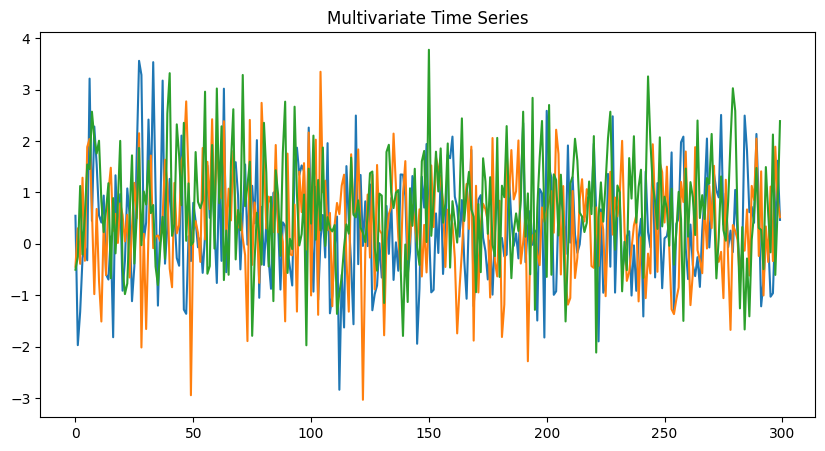

In [3]:
# Generate some observations with two normal distributions randomly mixed
n_timesteps = 100
n_vars = 3
# list comprehension of multivariate normals
X = torch.cat([dist.MultivariateNormal(torch.rand(n_vars), 
                                       torch.eye(n_vars)).sample((n_timesteps,)) for _ in range(n_vars)])
X = X[torch.randperm(n_vars*n_timesteps)]

print(f'X shape: {X.shape}')
# Plot the data as a multivariate time series
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(X)
ax.set_title('Multivariate Time Series')
plt.show()

In [4]:
# Split the data into training and validation (80-20) temporal
n_train = int(X.shape[0]*0.8)
X_train, X_valid = X[:n_train], X[n_train:]
print(f'X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}')

X_train shape: torch.Size([240, 3]), X_valid shape: torch.Size([60, 3])


## Sliding window Deep Convolutional Autoencoder

Architecture extracted from:
> Ali, M., et al., TimeCluster: dimension reduction applied to temporal data for visual analytics. The Visual Computer, 2019. 35(6): p. 1013–1026.

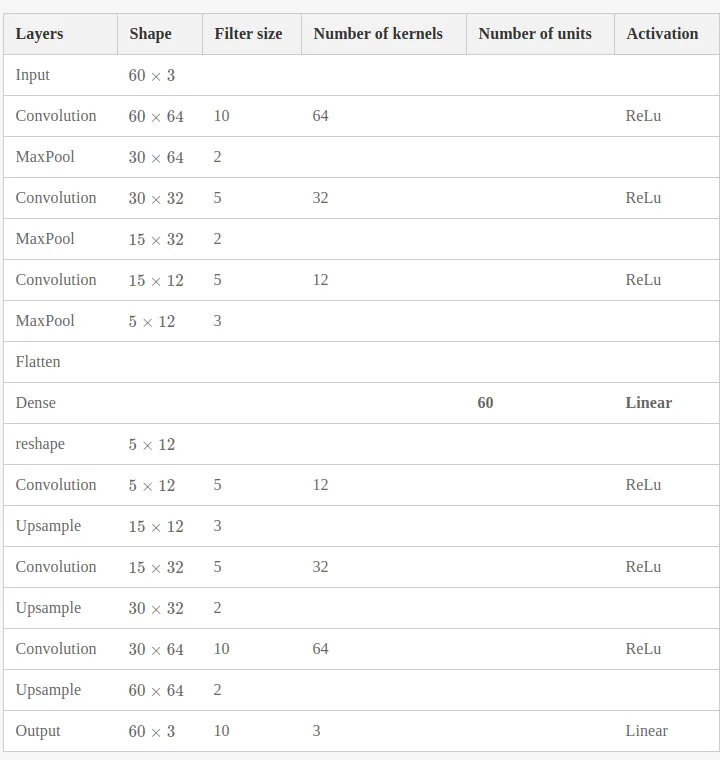

In [5]:
class Reshape(nn.Module):
    def __init__(self, *shape): 
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.shape[0], -1) if not self.shape else x.reshape(-1) if self.shape == (-1,) else x.reshape(x.shape[0], *self.shape)
    def __repr__(self): return f"{self.__class__.__name__}({', '.join(['bs'] + [str(s) for s in self.shape])})"

class SameConv1d(nn.Module):
    "Conv1d with padding='same'"
    def __init__(self, ni, nf, ks=3):
        super().__init__()
        self.ks = ks
        self.conv1d_same = nn.Conv1d(ni, nf, ks)
        self.pad = nn.ConstantPad1d

    @staticmethod
    def same_padding1d(seq_len, ks, stride=1, dilation=1):
        "Same padding formula as used in Tensorflow"
        p = (seq_len - 1) * stride + (ks - 1) * dilation + 1 - seq_len
        return p // 2, p - p // 2

    def forward(self, x):
        self.padding = self.same_padding1d(x.shape[-1], self.ks)
        return self.conv1d_same(self.pad(self.padding, value=0.)(x))

class DCAE(nn.Module):
    def __init__(self, c_in, seq_len, delta, nfs=[64, 32, 12], kss=[10, 5, 5],
                 pool_szs=[2,2,3], output_fsz=10):
        """
        Create a Deep Convolutional Autoencoder for multivariate time series of `d` dimensions,
        sliced with a window size of `w`. The parameter `delta` sets the number of latent features that will be
        contained in the Dense layer of the network. The the number of features
        maps (filters), the filter size and the pool size can also be adjusted."
        """
        super().__init__()
        assert all_equal([len(x) for x in [nfs, kss, pool_szs]], np.repeat(len(nfs), 3)), \
            'nfs, kss, and pool_szs must have the same length'
        assert np.prod(pool_szs) == nfs[-1], \
            'The number of filters in the last conv layer must be equal to the product of pool sizes'
        assert seq_len % np.prod(pool_szs) == 0, \
            'The product of pool sizes must be a divisor of the window size'
        layers = []
        for i in range_of(kss):
            layers += [SameConv1d(ni=nfs[i-1] if i>0 else c_in, nf=nfs[i], ks=kss[i]),
                       nn.MaxPool1d(kernel_size=pool_szs[i])]
        self.downsample = nn.Sequential(*layers)
        self.bottleneck = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('latent_in', nn.Linear(seq_len, delta)),
            ('latent_out', nn.Linear(delta, seq_len)),
            ('reshape', Reshape(nfs[-1], seq_len // np.prod(pool_szs)))
        ]))
        layers = []
        for i in reversed(range_of(kss)):
            layers += [SameConv1d(ni=nfs[i+1] if i != (len(nfs)-1) else nfs[-1],
                              nf=nfs[i], ks=kss[i]),
                       nn.Upsample(scale_factor=pool_szs[i])]
        layers += [SameConv1d(ni=nfs[0], nf=c_in, ks=output_fsz)]
        self.upsample = nn.Sequential(*layers)


    def forward(self, x):
        x = self.downsample(x)
        x = self.bottleneck(x)
        x = self.upsample(x)
        return x

In [6]:
foo = torch.rand(3, 1, 48)
m = DCAE(c_in=foo.shape[1], seq_len=foo.shape[2], delta=12)
m(foo).shape

torch.Size([3, 1, 48])

Sliding window approaches takes the window size 𝑤 as a hyper-parameter. 
This parameter has data-dependent effects on performance. When chosen 
too small, all windows tend to appear similar; when chosen too large, windows 
have a higher chance to overlap adjacent segments, blurring their discriminative power.

A simple, yet effective method for choosing the window size is the dominant 
frequency of the Fourier Transform.

In [7]:
# sliding window with the dataset
ws=12
X_sw_train = np.lib.stride_tricks.sliding_window_view(X_train, ws, axis=0)
X_sw_valid = np.lib.stride_tricks.sliding_window_view(X_valid, ws, axis=0)
X_sw_train.shape, X_sw_valid.shape


((229, 3, 12), (49, 3, 12))

In [8]:
# Create the datasets
train_dataset = TensorDataset(tensor(X_sw_train), tensor(X_sw_train))
valid_dataset = TensorDataset(tensor(X_sw_valid), tensor(X_sw_valid))

# Create the dataloaders 
bs = 8
dls = DataLoaders.from_dsets(train_dataset, valid_dataset, bs=bs, shuffle=True)
xb, yb = dls.one_batch()
xb.shape, yb.shape

/home/victor/.local/lib/python3.10/site-packages/fastai/torch_core.py:137: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  t = torch.as_tensor(x, **kwargs)


(torch.Size([8, 3, 12]), torch.Size([8, 3, 12]))

/home/victor/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,time
0,1.182453,1.030194,00:00
1,1.152444,0.997454,00:00
2,1.130618,0.961318,00:00
3,1.109086,0.938680,00:00
4,1.084657,0.924184,00:00
5,1.061999,0.926611,00:00
6,1.047944,0.927385,00:00
7,1.027580,0.887473,00:00
8,1.011799,0.902175,00:00
9,1.003283,0.885578,00:00


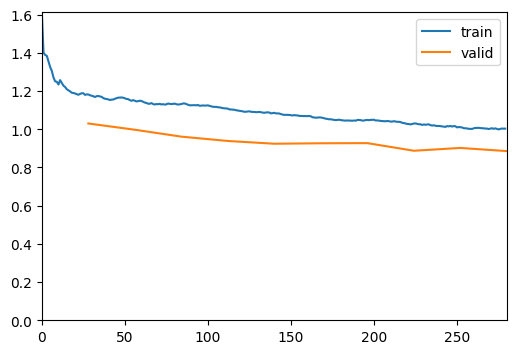

In [14]:
model = DCAE(c_in=n_vars, seq_len=ws, delta=6)
learn = Learner(dls, model=model, loss_func=nn.MSELoss(), cbs=[ShowGraphCallback()])
learn.fit(10, lr=1e-3)

In [16]:
activations = []
def hook_fn(m, i, o): activations.append(o) # hook function to retrieve the latent space
preds = learn.get_preds(cbs=HookCallback(modules=[model.bottleneck[1]], hook=hook_fn))
# Stack all activations into a single tensor
activations = torch.cat(activations, dim=0)
activations.shape

/home/victor/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


torch.Size([49, 6])

## Time-lagged autoencoder

> As described in: Christoph Wehmeyer and Frank Noé. Time-lagged autoencoders: 
deep learning of slow collective variables for molecular kinetics. J. Chem. Phys., 
148(24):241703, jun 2018. doi:10.1063/1.5011399.​

In [62]:
class TimeLaggedAutoencoder(nn.Module):
    """
    A time-lagged autoencoder model for representation learning.

    Args:
        input_dim (int): The dimensionality of the input data.
        latent_dim (int): The dimensionality of the latent space.
        hidden_layers (list): A list of integers representing the sizes of the hidden layers.

    Attributes:
        encoder (nn.Sequential): The encoder module of the autoencoder.
        decoder (nn.Sequential): The decoder module of the autoencoder.
    """

    def __init__(self, input_dim, latent_dim, hidden_layers):
        super(TimeLaggedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layers[0]),
            nn.ReLU(True),
            nn.Linear(hidden_layers[0], latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_layers[-1]),
            nn.ReLU(True),
            nn.Linear(hidden_layers[-1], input_dim),
            nn.ReLU(True) # or use Sigmoid if the input data is normalized
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [63]:
bs = 2
foo = torch.rand(bs, n_vars) # TLA expects single time steps, not windows
m = TimeLaggedAutoencoder(input_dim=foo.shape[1], latent_dim=3, hidden_layers=[10, 5])
m(foo)

tensor([[0.1442, 0.0000, 0.2825],
        [0.1777, 0.0000, 0.2597]], grad_fn=<ReluBackward0>)

In [64]:
# Create the datasets directly from X, not from the sliding window version
train_dataset = TensorDataset(tensor(X_train), tensor(X_train))
valid_dataset = TensorDataset(tensor(X_valid), tensor(X_valid))

# Create the dataloaders
bs = 8
dls = DataLoaders.from_dsets(train_dataset, valid_dataset, bs=bs, shuffle=True)
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3]), torch.Size([8, 3]))

epoch,train_loss,valid_loss,time
0,1.217163,1.282754,00:00
1,1.201076,1.226717,00:00
2,1.166129,1.157974,00:00
3,1.125840,1.083722,00:00
4,1.086163,1.025800,00:00
5,1.036068,0.953743,00:00
6,0.977941,0.859272,00:00
7,0.923791,0.799325,00:00
8,0.866935,0.760328,00:00
9,0.831481,0.733966,00:00


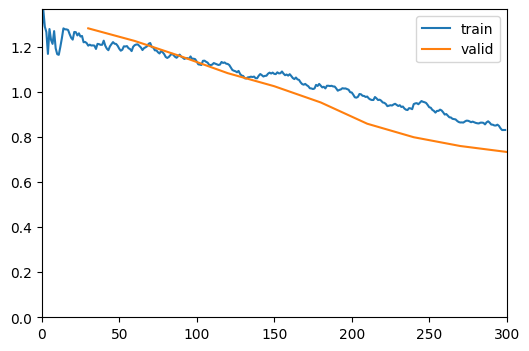

In [69]:
model = TimeLaggedAutoencoder(input_dim=n_vars, latent_dim=3, hidden_layers=[10, 5])
learn = Learner(dls, model=model, loss_func=nn.MSELoss(), 
                cbs=[ShowGraphCallback()])
learn.fit(10, lr=1e-3)

In [79]:
activations = []
def hook_fn(m, i, o): activations.append(o) # hook function to retrieve the latent space
preds = learn.get_preds(cbs=HookCallback(modules=[model.encoder[-1]], hook=hook_fn))
# Stack all activations into a single tensor
activations = torch.cat(activations, dim=0)
activations.shape

torch.Size([60, 3])

## TODO

Compare the embedding space of each of the models, cluster the embedding space
(you can use sklearn's kmeans or HDBSCAN for that), and plot the embeddings in 
a lower manifold through PCA. 

Try plotting the embedding cluster along with the original data to see if you 
can find any pattern